## Model Analysis Notebook

In this notebook, we train, test, and evaluate the performance of an LSTM model in wind speed prediction and compare results to the persistence method, which is a common benchmark for wind speed prediction algorithms.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

import sklearn
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import tensorflow as tf
import keras
from keras.layers import Input, LSTM, Dense, Dropout, Flatten

In [2]:
# Define how many time steps will be used in observation and prediction
n_past = 24 # The last day of data
n_future = 24 # The next day of data
n_features = 3

# Set the universal font size for matplotlib
plt.rcParams['font.size'] = 11

In [3]:
# Define a function to split the series using a sliding window
def split_series(series, n_past=n_past, n_future=n_future, offset=0):
    X, y = list(), list()
    for i in range(int(len(series)/n_past)-1):
        X.append(series[i*n_past : i*n_past + n_past, :])
        y.append(series[offset + i*n_past + n_past : offset + i*n_past + n_past + n_future, :])
    return np.array(X), np.array(y)

In [4]:
# Process and split the data for a site given its filename
def prep_data(filename, cy=2015):
    # Import the data for a single point
    data = pd.read_csv("Data/NOW-23 Great Lakes [2000-2020] 60min/" + filename, index_col=0)

    # Restrict the data to the last 5 years, giving us 4 years of training and 1 year of testing data
    data = data.iloc[int(len(data)*(cy-2000)/20):]

    # Split the data into training and testing samples
    cutoff = int(len(data)*0.8)
    test_data = data[cutoff:]
    data = data[:cutoff]
    
    # Designate which columns are used for training
    columns = [6, 7, 8]
    
    # Normalize the testing and training data
    test_data.iloc[:, columns], test_norms = normalize(test_data.iloc[:, columns], axis=0, norm='max', return_norm=True)
    data.iloc[:, columns], train_norms = normalize(data.iloc[:, columns], axis=0, norm='max', return_norm=True)

    # Split the data into series for training
    X_train, y_train = split_series(np.array(data.iloc[:, columns]), n_future=1, offset=24-1)
    X_test, y_test = split_series(np.array(test_data.iloc[:, columns]), n_future=1, offset=24-1)

    # Adjust the expected output to contain only the wind speed
    y_train, y_test = y_train[:, :, 2], y_test[:, :, 2]
    
    return X_train, y_train, X_test, y_test, train_norms, test_norms

In [5]:
# Define the model architecture
def define_model():
    # Original model used for testing
    '''
    model = keras.models.Sequential()
    model.add(Input(shape=(n_past, n_features)))
    model.add(LSTM(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(1, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.compile(optimizer='adam', loss='mae')
    '''


    # Lighter model used for additional training
    model = keras.models.Sequential()
    model.add(Input(shape=(n_past, n_features)))
    model.add(LSTM(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(1, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.compile(optimizer='adam', loss='mae')

    return model

In [6]:
model = define_model()
model.summary()
model.input_shape

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,425 (5.57 KB)

 Trainable params: 1,425 (5.57 KB)

 Non-trainable params: 0 (0.00 B)

(None, 24, 3)

In [ ]:
# Train one model with data starting at different years
df = pd.DataFrame()
df['Years'] = list()
df['MAE'] = list()
for year in range(2000, 2020):
    print(f"{year}")

    X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data('7871.csv', cy=year)
    model = define_model()
    model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=128)

    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test[:, 0] * test_norms[2], predictions * test_norms[2])

    df.loc[len(df) + 1] = [int(year), mae]

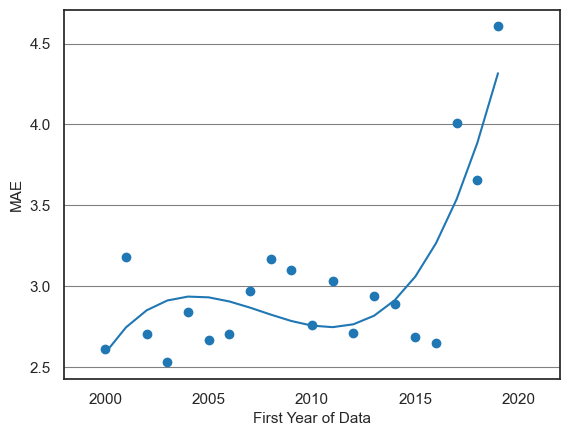

In [69]:
df = pd.read_csv(r'Data\Raw Experiment Data\starting year experiment.csv')
# Display the data for use as a figure
ax = plt.axes()
ax.set_facecolor("white")
plt.xlabel('First Year of Data')
plt.ylabel('MAE')
plt.xlim(1998, 2022)
plt.scatter(df['Years'], df['MAE'])
y_lim = ax.get_ylim()
plt.grid(True, axis='y', color='grey')

# Plot the line of best fit
def get_y_value(x, coeffs):
    y = 0
    for i in range(len(coeffs)):
        y += coeffs[i]*x**(len(coeffs)-1-i)
    return y

coeffs = np.polyfit(df["Years"], df['MAE'], 3)
plt.plot(df["Years"], get_y_value(df["Years"], coeffs))

In [ ]:
## Train one model with a varying number of epochs
df = pd.DataFrame()
df['Epochs'] = list()
df['MAE'] = list()
for epoch in range(10, 160, 10):
    print(f"{epoch}")

    X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data('7871.csv')
    model = define_model()
    model.fit(X_train,y_train,epochs=epoch,validation_data=(X_test,y_test),batch_size=128)
        
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test[:, 0] * test_norms[2], predictions * test_norms[2])
        
    df.loc[len(df)+1] = [int(epoch), mae]

[-5.15653721e-08  1.96498066e-05 -2.45845681e-03  2.78118136e+00]


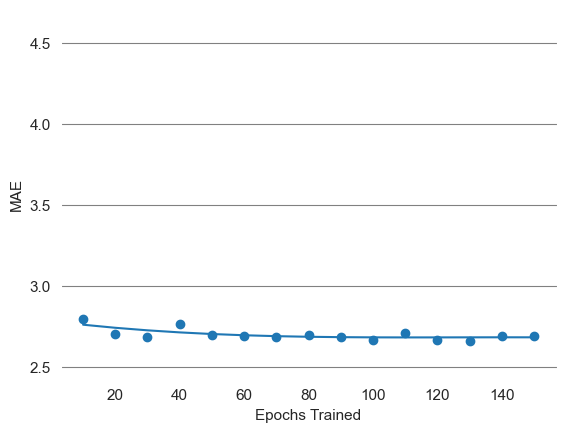

In [42]:
df = pd.read_csv(r'Data\Raw Experiment Data\epoch experiment.csv')
# Display the data for use as a figure
ax = plt.axes()
ax.set_facecolor("white")
plt.xlabel('Epochs Trained')
plt.ylabel('MAE')
plt.ylim(y_lim)
plt.scatter(df['Epochs'], df['MAE'])
plt.grid(True, axis='y', color='grey')

# Plot the line of best fit
coeffs = np.polyfit(df["Epochs"], df['MAE'], 3)
print(coeffs)
plt.plot(df["Epochs"], get_y_value(df["Epochs"], coeffs))

In [52]:
# Train models for every selected site
i = 1
for filename in os.listdir("Data/NOW-23 Great Lakes [2000-2020] 60min"):
    print(f"Point number {i} of 100")
    i += 1

    model = define_model()
    
    X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data(filename, cy=2015)
    
    model.fit(X_train,y_train,epochs=50,validation_data=(X_test,y_test),batch_size=128)
    model.save("Data/Models/" + filename[:-4] + ".keras")

Point number 1 of 100
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.2494 - val_loss: 0.2580
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2092 - val_loss: 0.2093
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1616 - val_loss: 0.1612
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1419 - val_loss: 0.1506
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1367 - val_loss: 0.1545
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1314 - val_loss: 0.1544
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1329 - val_loss: 0.1507
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1282 - val_loss: 0.1486
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1201 - val_loss: 0.1468
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1251 - val_loss: 0.1449
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1245 - val_loss: 0.1461
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

In [87]:
# Test models for every selected site
mae, sites = list(), list()

for filename in os.listdir("Data/Models"):

    X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data(filename[:-6] + '.csv', cy=2015)
    model = keras.saving.load_model("Data/Models/" + filename)
    model.compile(optimizer='adam', loss='mae')
    
    predictions = model.predict(X_test)
    mae.append(mean_absolute_error(y_test[:, 0] * test_norms[2], predictions * test_norms[2]))
    sites.append(filename[:-6])
    print(mae[-1])
df = pd.DataFrame()
df['MAE'] = pd.Series(mae)
df['SiteID'] = pd.Series(sites)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3.5270664756335517
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3.3074529520504137
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3.0158627842109245
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2.7071389364072793
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2.858025447186375
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2.9077289321160444
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3.368300581827213
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2.90032594076626
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3.484278090012635
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3.2564071141986948
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3.508286328190909
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2.6689131898031184
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2.774175951543279
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3.010797130424939
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3.5467168471451207
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3.6297052722451575
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2.9125062577512253
12/12

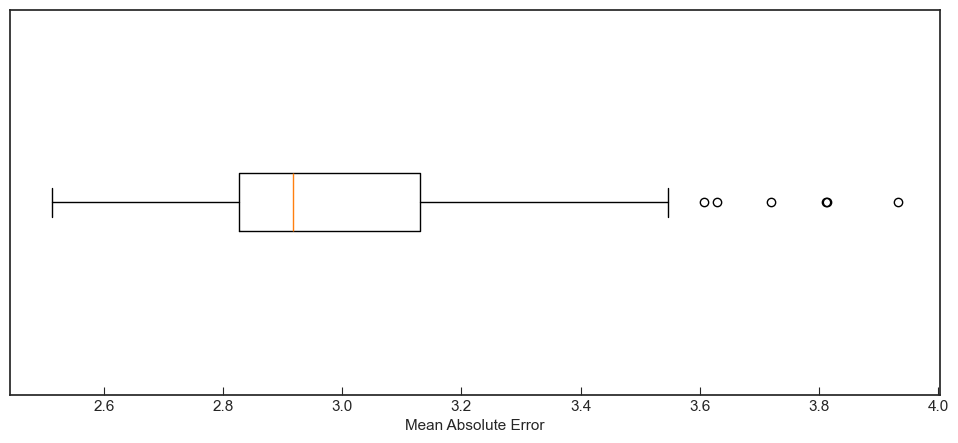

In [88]:
df = pd.read_csv(r'Data\Raw Experiment Data\starting year experiment.csv')

# Generate a box plot to describe the MAE distribution for use as a figure
fig = plt.gcf()
frame = plt.gca()
fig.set_size_inches(12, 5)
frame.axes.get_yaxis().set_visible(False)

plt.style.use('seaborn-v0_8-ticks')
plt.boxplot(df['MAE'], vert=False)
plt.xlabel("Mean Absolute Error")
plt.tick_params(axis='x', which='major', reset=True, direction='in', top=False)
plt.show()

In [89]:
# We can print out some statistics of the distribution in detail
print(f"Mean: {np.average(df['MAE'])}")
print(f"Median: {np.median(df['MAE'])}")
print(f"Standard Deviation: {np.std(df['MAE'])}")
print(f"n: {len(df['MAE'])}")

Mean: 3.0024898514800045
Median: 2.9171861505009113
Standard Deviation: 0.29748344752083916
n: 100


In [92]:
# Finally, we repeat this analysis with a persistence model that uses the wind speed from 24h before as a prediction, demonstrating the superiority of the LSTM model

mae, rmse, sites = list(), list(), list()

for filename in os.listdir("Data/Models"):

    X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data(filename[:-6] + '.csv', cy=2015)

    predictions = [x[-1] for x in X_test[:, :, -1]]
    mae.append(mean_absolute_error(y_test[:, 0] * test_norms[2], np.array(predictions) * test_norms[2]))
    rmse.append(np.sqrt(mean_squared_error(y_test[:, 0] * test_norms[2], np.array(predictions) * test_norms[2])))
    sites.append(filename[:-6])

df1 = pd.DataFrame()
df1['MAE'] = pd.Series(mae)
df1['RMSE'] = pd.Series(rmse)
df1['SiteID'] = pd.Series(sites)

In [93]:
# We compare the persistence model on a variety of loss metrics
print(f"Average MAE of the persistence model: {np.average(df1['MAE'])}")
print(f"Median MAE of the persistence model: {np.median(df1['MAE'])}")
print(f"Average RMSE of the persistence model: {np.average(df1['RMSE'])}")
print(f"Median RMSE of the persistence model: {np.median(df1['RMSE'])}")

print("\n")
print(f"The persistence model has a higher MAE by {(np.average(df1['MAE'])/np.average(df['MAE']) - 1) * 100}%")
print(f"Median difference: {(np.median(df1['MAE'])/np.median(df['MAE']) - 1) * 100}%")
# Unsurpisingly, the both the median and average MAE of the persistence model are around 25-30% higher than the average LSTM model MAE over all sites

Average MAE of the persistence model: 3.8447835078534025
Median MAE of the persistence model: 3.7822513089005234
Average RMSE of the persistence model: 4.935832391405675
Median RMSE of the persistence model: 4.849352018963687


The persistence model has a higher MAE by 28.053172468117072%
Median difference: 29.654095205788344%


In [94]:
# To describe the differences in train time with different model parameters, we train 3 models, each encompassing the 100 selected points in the study.
df = pd.DataFrame()
df['Average MAE'] = list()
df['Median MAE'] = list()
df['Average RMSE'] = list()
df['Median RMSE'] = list()
df['Train_time'] = list()
df['Train_time std'] = list()

for pair in [[100, 2000], [100, 2015], [50, 2015]]:
    # Train models for every selected site

    mae, rmse, time_elapsed = list(), list(), list()
    i = 1
    for filename in os.listdir("Data/NOW-23 Great Lakes [2000-2020] 60min"):
        print(f"Point number {i} of 100")
        i += 1
        
        start_time = datetime.now()
        model = define_model()
        X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data(filename, cy=pair[1])
        model.fit(X_train,y_train,epochs=pair[0],validation_data=(X_test,y_test),batch_size=128)

        predictions = model.predict(X_test)
        mae.append(mean_absolute_error(y_test[:, 0] * test_norms[2], np.array(predictions) * test_norms[2]))
        rmse.append(np.sqrt(mean_squared_error(y_test[:, 0] * test_norms[2], np.array(predictions) * test_norms[2])))
    
        time_elapsed.append((datetime.now() - start_time).total_seconds())
    df.loc[len(df)+1] = [np.average(mae), np.median(mae), np.average(rmse), np.median(rmse), np.average(time_elapsed), np.std(time_elapsed)]
df['Model'] = ['100 epochs, 20 years', '100 epochs, 5 years', '50 epochs, 5 years']

Point number 1 of 100
Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2035 - val_loss: 0.1313
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1184 - val_loss: 0.1333
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1125 - val_loss: 0.1314
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1116 - val_loss: 0.1298
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1073 - val_loss: 0.1258
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1056 - val_loss: 0.1244
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1040 - val_loss: 0.1223
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1023 - val_loss: 0.1228
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1021 - val_loss: 0.1228
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1013 - val_loss: 0.1209
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1003 - val_loss: 0.1180
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 

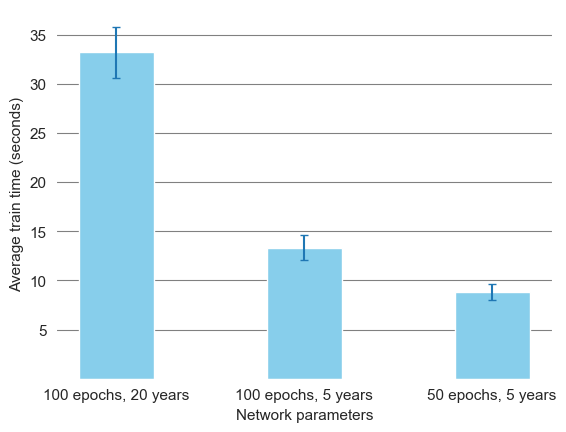

In [18]:
df = pd.read_csv("Data/Raw Experiment Data/Train Time Experiment.csv")

# Now we can generate a figure to demonstrate the significant change in train time between the models
ax = plt.axes()
ax.set_facecolor("white")
ax.set_yticks(range(5, 40, 5))
plt.grid(True, axis='y', color='grey')
plt.bar(df['Model'], df['Train_time'], width=0.4, color="skyblue")
plt.errorbar(df['Model'], df['Train_time'], yerr=df['Train_time std'], capsize=3, linestyle="")
plt.ylabel("Average train time (seconds)")
plt.xlabel("Network parameters")
plt.show()

In [ ]:
# We also compare the models to persistence, finding no major differences between the models in performance but significant improvements over persistence
df.loc[len(df)+1] = [np.average(df1['MAE']), np.median(df1['MAE']), np.average(df1['RMSE']), np.median(df1['RMSE']), 0, "Persistence"]
df.drop('Train_time', inplace=True, axis=1)
display(df)